# Sep 27th, 2021

**Motivation**: Figures <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from IPython.display import IFrame

width, height = 850, 1135
figs_dir = '../../_extras/fig_sketches'
os.listdir(figs_dir)

[
    'Fig-8.pdf',
    'Fig-7.pdf',
    'Fig-3.pdf',
    'Fig-2.pdf',
    'Fig-6.pdf',
    'Fig-1.pdf',
    'Fig-5.pdf',
    'Phys-Analogy.pdf',
    'Fig-4a.pdf',
    'Fig-4b.pdf',
    'Fig-9.pdf'
]

## Figure 1

### What:
---
**Intro, experimental setup, overal approach, set the stage**

---

Specifically, this figure shows the following:
- This study is about functional connectivity.
- Using simultaneous BOLD and $Ca^{2+}$ data from mice.
- Communicate how we define ROIs: somehwere in this figure there is a 3D rendering of ROIs.
- A very crude, big picture illustration of the algorithm used.
    - Should emphasize: the main result of the algorithm is $\pi_i$. Illustrate what it means using an example ROI that has mixed membership
    - Also it should be clear this is an explicit generative model of network edges.  More details how to show this below
- At the end of this figure we are ready to see the main results.

### How:
More details about how to achieve this:
- On top left there is a mouse cartoon, and somehow showing that we get BOLD as well as $Ca^{2+}$ data from same animals simultanesouly.  Brainstorming with Yale people can be helpful, and specially with this part of the figure.
- Then we show the timeseries are used to compute covariance matrix, which is thresholded to give us a binary graph that represents interactions in the brain.
- Once again, we emphasize that there are two data modalities throughout this study:
	- BOLD will be shown with Crimson, or Dark Red, or Copper color.
    - $Ca^{2+}$ will be shown with Green that reminds us about the fluorescence.
- These binarized graphs go into the algorithm as inputs.  The algorithm then tries to explain the links (or non links) with an explicit generative model.
- The most important things about the algorithm are visualized:
    - First, some how we show every ROI is allowed to belong to more than one communities: this is the main message that everyone should immediately see from this figure.
    - Therefore, the membership vector is like a die (each ROI has its own die, and the algorithm returns a bad of dice for the whole brain)
    - Generative process:
        - (a) roll die for $i$ (i.e. sample from $\pi_i$)
        - (b) roll die for $j$ (i.e. sample from $\pi_j$)
        - (c) if you get the same answer then there is a link between $i$ and $j$
- At the end of the figure, we somehow communicate that we run the algorithm and receive two bags of dice, one for each data modality.  Then the reader will be ready to see in the next figure how these bags of dice are distributed.

In [3]:
path = pjoin(figs_dir, 'Fig-1.pdf')
display(IFrame(path, width=width, height=height))

---
---
---

## Figure 2

### What:
---
**Main result: mouse FC is significantly overlapping**

---
This figure shows:
- The resulting overlapping communities (how they look like on cortex and subcortex) and also the distribution of membership values.
- Also, to emphasize this is a link communituy, there is a mouse brain on which there are some nodes and the links are colored according to the disjoint approximation.  One for each data modality. This part is inspired by the main figure in Blei PNAS.
- There are 4 bins spanning (0.2, 1.0).  The last bin has special meaning.
- I think this figure should have a subfigure specially emphasizing the last bin.
- I propose plotting the bootstrapped distribution of the logit transformed version of the last bin.

### Logit transform of last bin:

- The last bin shows proportion of nodes that have a membership value of 0.8 or larger in a given community.  Let us call this number $\theta_{k, (0.8, 1]}$.  We have $\theta_{k, (0.8, 1]} \in (0, 1)$, since proportions cannot be negative or greater than one.
- Now consider the logit transformed version of this number: $u = \text{logit}(\theta) = \log(\frac{\theta}{1 - \theta}).$

- One can show that $\theta \in (0, 1)$ implies $u \in (-\infty, \infty)$
- A t-test now makes a lot more sense for $u$ rather than $\theta$.
- Thus, we can test for significante in a more **proper** way.  I'm expecting to get ridiculously small p-values, indicating solid evidence for overlap.

- I think it would be useful to just throw in a few values from LFR showing that there is a nice correspondence between the distribution of last bin values with the amount of ground truth overlap. Although, this would reduce the coherence of this figure so I'm not sure.  Any thoughts on this?

In [4]:
path = pjoin(figs_dir, 'Fig-2.pdf')
display(IFrame(path, width=width, height=height))

---
---
---

## Figure 3

### What:
---
**Comparison to baseline graphs** <br>
Addressing: what if these results are an artifact of the algorithm used?

---

First we define the baseline models used:

1. Well known ***LFR*** graphs with controllable amounts of overlap.
2. Well known ***Config*** model, and less well known ***Clustered Config*** model.

Then, these baselines are used to make the following claims:
- The algorithm used is pretty good in what we ask it to do: it detects the correct amount of overlap in LFR graphs.
- How does topology of the real graph contribute to this overlap?  Is it the degree distribution, or is it the clustering coefficient that's driving this?
- Would randomizing the graph topology change the results? The answer is yes.
    - We see that Config shows more overlap than the real model, and Clust-Config shows less overlap.
    - Thus, we conclude that the real graph has a nontrivial topology (i.e. wiring between nodes) that leads to the way things are organized.

### More details on how to achieve this:
- First, we introduce LFR.  On the top left corner of the figure there are two represntative adjacency matrices for LFR graphs: one totally disjoint, and the other overlapping. This immediately gives the impression why we use them to test our claims.
- Next, we talk about the randomized baselines.  There is a bar plot showing that Config and Config-Clust are good baselines: they have the same degree distribution like the real graph, and the clustered version has the same clustering coefficient (includes bootstrap + significance testing).
- Therefore, any difference we see between these random baselines and the real one must be due to the nontrivial topology of the real one.
- In Fig 2 the focus was on communities (we plotted the membership distributions for communities). Here the focus is primarily on nodes.
- We already showed that the communities are all significantly overlapping.  What about the nodes?  How many of them have mixed-memberships, and how many only like to belong to a single community?
- To this end, we define the maximum membership value for each node: $x_i := \max_{k} (\pi_{ik}).$

- This is an interesting number.  It will tell us to what extent is a node overlapping or disjoint.
- The membership values are bounded and they add up to one.  In other words, $\pi_{ik} \in (0, 1)$ for all $k$, and $\sum_k \pi_{ik} = 1$.  This implies $x_i \in (1/k, 1)$.
- For a graph with $N$ nodes, there are $N$ numbers $\{x_i : i = 1, \dots, N\}$.  We plot the distribution of these numbers per graph, and compare to LFR, as well as random baselines.
- We see that for LFR with no overlap all $x_i$ are greater than $0.8$.  And there is a nice gradient of increased density in lower values, as we crank up the amount of overlap.
- I suggest using an Empirical CDF (ECDF) plot along with showing just the density of $x_i$. This visualization aids the readers in seeing the truth: that at least half of the nodes in mouse FC are overlapping.  Hence, a disjoint approach does not do justice.
- The fact that $x_i \in (1/k, 1)$ is interesting.  In the limit of $k = 1$, all nodes are forced to be disjoint and belong to the one community: the entire network.
- We can use this oppourtinity to test our results by varying $k$.  This way, we can better understand how the proportion of overlapping nodes depends on the choice of $k$. Looking at the two extreme limits of $k = 1$ and $k \to \infty$ is informative here, but so is just plotting the proportion detected as disjoint as a function of $k$.  Is there a robust plateauing effect here?
- Once again, we show that our results make sense on LFR graphs, therefore, our claim will be strong.

In [5]:
path = pjoin(figs_dir, 'Fig-3.pdf')
display(IFrame(path, width=width, height=height))

---
---
---

## Figure 4

### What:
---
**Systematic comparison of results for BOLD and $Ca^{2+}$**<br>
Here: only at the adjacency matrix and graph level

---


>#### Edit Sept 27th:
I think Fig 4 hurts the coherence and smooth flow of the paper.  The content discussed here can be its own paper, or contribute as additinal analysis in a future paper.  I still left it here and didn't take it out to get feedback.

- Ok, so far in 3 figs we have established:
    1. What this study is about, big picture goals.
    2. Characterizing overlapping communities.
    3. Solid evidence that mouse FC graph is overlapping in a nontrivial way: **justification** for using an overlapping approach for the **rest of the study**. 
  
- Now it is time to look at the two data modaliteis carefully to find out in what ways they are similar and different.
- I think this is an excellent opportunity to study the differences and similarities between the two modalities at the network level only, and benchmark things. This will be useful in the future when we starts at the direct time series level to study dynamic FC.
- Here we want to address a simple question: what aspects of our results is present/valid for both Ca and BOLD, and what parts differ in what ways.

### 1. Compare covariance matrices:
- First off, let's look at the covariance matrices.  Each element $w_{ij}$ is correlation between time series recorded from $i$ and $j$.
- If we restrict our analysis to the ROIs that are present in 2d Ca space, then we can directly compare things between the two.
- Why compare adjacency matrices?  Linear correlations are informative about the interactions going on in the system.  We don't have a good theory (any theory) to understand these correlations properly, but at least we can see if we get the same structure from both data modalities.
- Rank correlation betweeen the two covariance matrices can be used to study similarity, and specially, which edges are most similar across datasets, and which edges are most dissimilar.  Is this due to something interesting, or just noise, or other errors in data processing?
- Rank correlation because global signal regression shifts distribution of correlations quite a lot.
- It is important to make comparisons at different frequency bands.  The adjacency matrix is well defined for the raw signals as wells as bandpassed ones.  How does this number (similarity of adj matrices) vary as a function of bandpassing?

### 2. Compare graph topologies (thresholded)
- It is interesting to look at graph topology at different thresholds.
- Compare graph topologies at different thresholds, for $Ca^{2+}$, BOLD,  but also within the same data modality but between-subject, within-same-subject and so on. There are many interesting combinations, this will become clearer later.
- At each level of this figure, the within-subject, and within-session similarities are used as baseline comparison.

### How:
- I don't have a clear plan about how exactly to do this yet, but here are some rough ideas.
- For topological distance, I like to use Network Portrain Divergence. It's based on solid information thoeretic principles and shows reliable results (I was happy last time i tried it).  Might change my mind later.
- The adjacency matrices can be directly compared in Fourier domain.  Each frequency has a non-negative contribution to each element of the adjacency matrix $w_{ij}$.
- By studying this problem in the Fourier domain, we can learn whether we gain nontrivial amount of information about the underlying dynamics by using $Ca^{2+}$ data (I am certain we do, but have to quantify it and provide evidence).

In [6]:
path = pjoin(figs_dir, 'Fig-4a.pdf')
display(IFrame(path, width=width, height=height))

In [7]:
path = pjoin(figs_dir, 'Fig-4b.pdf')
display(IFrame(path, width=width, height=height))

---
---
---

## Figure 5

### What:
---
**Comparing our results to disjoint results**\
Including the recently published ones about mouse FC

---

- The goal is to show we recover whatever disjoint results you can think of: be it existing results by other labs that have used non-overlapping approaches, or application of disjoint clustering algorithms directly on the time series data.
- Shows that the argmax, disjoint limit of our results reduces to existing results.
- Also, compare to hierarchical clustering results, which I already have shown we get very similar community structures.
- Just like every other figure, we have both BOLD and $Ca^{2+}$.
- This figure includes comparison of BOLD with $Ca^{2+}$ at the community structure level.  Maybe this should be Fig 4, and 4 should be 5?

### How:
- At the disjoint approxmination level, Dice coefficient will be used to quantify similarity scores.
- Specifically, I want to download the [DMN mask published last year](https://www.sciencedirect.com/science/article/pii/S0896627320308898).  They define DMN by applying ICA and choosing two thresholds.
- The interesting thing is that we compare between:
    - The disjoint limit of our overlapping results (argmax): a **stochastic** algorithm that acts on the interaction graph.
    - Recent ICA results: is simple **generative** model on time series.
    - Hierarchical clustering (Ward's Linkage): dumb, **brute-force**, agglomerative approach also on time series.
- If they all give the same answer, then we can be more confident about robustness of our results.  Yet another validation for our overlapping philosophy. That is, overlapping mindset gives you what other algorithms give, plus way more than that: dense memberships.
- The comparison between BOLD and $Ca^{2+}$ can be made at several levels:
    1. Dice coefficient for argmax approximation.
    2. Dot product between membership vectors
- Again, between-subject, and same-subject but between-session numbers will be used as baselines to make sense of these quantities.

In [8]:
path = pjoin(figs_dir, 'Fig-5.pdf')
display(IFrame(path, width=width * 1.02, height=height))

---
---
---

## Figure 6

### What:
---
**Study of node entropies**

---

- Here we focus on node entropies: a quantity that our overlapping algorithm provides us, but disjoint ones do not.
- In the previous figure we showed that existing results in the literature can be obtained as a special case of our approach.
- Now, in this figure the goal is to show what else we can learn about the brain by using an overlapping approach, that is missing in a disjoint parcellation.
- In network science literature [people call this bridgeness](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.77.016107). A reg plot showing bridgeness vs entropy is useful to have at some corner: shows that they literally are the same thing.  I did this before, I got spearman $\rho \approx 0.98$ between the two quantities.
- The entropy values are visualized on the cortex, for both $Ca^{2+}$ and BOLD.
- Entropy-Degree cartography map reveals interesting structures that would be burried down if we used simple centrality measures.
- The entropy exis adds more info that is not captured by hubness or eigenvecgor centrality or all the other rather nonsensical measures people have talked about in FC literature.
- Also show [something like fig 2 here](https://cs.stanford.edu/people/jure/pubs/communities-pieee14.pdf), and say that both types of overlap are present in our data:
	1. Dense overlap: high-degree / high-entropy,
    2. Sparse overlap: low-degree / high-entropy.
    
- To do this plot represntative parts of adjacency matrix for both dense and sparse overlaps. Yes they both exist in our data.

In [9]:
path = pjoin(figs_dir, 'Fig-6.pdf')
display(IFrame(path, width=width, height=height))

---
---
---

## Figure 7

### What:
---
**Relationship between entropy and anatomical connectome**<br>
Possible result: why certain nodes have high entropies?

---

- Obvious intuition about high entropy nodes: they act as coordinators in the brain.  They talk a little bit to a lot of other regions.  Therefore, they will have a little bit of correlation with many other regions.
- If this is true, then anatomical hubs or connector hubs will be more likely coincide with functional high entropy nodes.
- A reg plot of anatomical degree and functiona entropy should reveal this relationship if it exists.
- Here it would be useful to have a comparison between results obtained from other overlapping algorithms:
    1. [OSLOM](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0018961) is a good one (highly cited)
    2. [Community-Affiliation Graph Model (AGM)](https://cs.stanford.edu/people/jure/pubs/communities-pieee14.pdf) is good
    3. [Edge-centric FC](https://www.nature.com/articles/s41593-020-00719-y)
- Edge FC predicts high entropy for visual cortex and low entropy for association areas, while SVINET and the other algorithms predict the opposit.  Which prediction better captures the underlying truth?
- A reg plot beteen anatomical degree and entropy as estimated by all these algorithms shall reveal this.  Which reg plot has a nonzero positive slope?
- I think the motivation behind Edge FC algorithm is nice and respectable, but something must be horribly wrong. Otherwise, it wouldn't have made such nonesense predictions.
- I think it is important to examine this in Fig 7.  That paper got into nature neurosceince so people need to know if it's actually nonesense.  Maybe I judge too harshly, but this is something we can test.

In [10]:
path = pjoin(figs_dir, 'Fig-7.pdf')
display(IFrame(path, width=width, height=height))

---
---
---

## Figure 8

### What:
---
**Define and present a node similarity measure, and more**<br>
relationship between our findings and FC gradients

---

This figure has several goals.  First, it wants to communicate that the question of community finding is not only about finding tightly knit subgraphs.  It is more than that.  From [this paper](https://jmlr.org/papers/v18/16-480.html):

> From a more general point of view, community structures may also refer to groups of vertices that connect similarly to the rest of the graphs without having necessarily a higher inner density.

How does one find ***groups of vertices that connect similarly*** to the rest of the graph?  Let me define a node similarity measure that is freely available to us as a side product of SVINET.

### Define a node similarity measure:
- The algorithm is built on the idea that membership values can be used to infer whether two nodes will be linked or not.
- For aligned $\pi_i$ and $\pi_j$ there is a higher chance of drawing the same community indicator.  This means a higher chance of having a link between $i$ and $j$.
- Express this mathematically by defining $Y_{ij} = \sum_k \pi_{ik} \pi_{jk}$ (in the full model this is a weighted sum $Y_{ij} = \sum_k \beta_k \pi_{ik} \pi_{jk}$, where $\beta_k$ is community strenght for different $k$).
- This quantity can be interpreted as a node similarity measure, because:
    - By definition, $Y_{ij}$ is the probability for existence of a link between $i$ and $j$.
    - Take $i$-th row of this matrix and call it $Y_i$. This vector essentially has dense information about likelihood of node $i$ connecting to every other node in the graph.
    - ***Main insight***: if two nodes $a$ and $b$ are **similar**, then they will have a similar $Y_a$ and $Y_b$.  In other words, the way you connect to everybody else defines who you are.
    - If the way $a$ connects to everybody esle is very similar to the way $b$ connects to everybody else, then they are similar and they will most likely be in the same community.
    - Therefore, saying $a$ and $b$ similar is equivalent to $\cos(Y_a, Y_b)$ is large.
    - We can think of $Y_{ij}$ as a questionare in a social science study. If two people answer similarly to a large set of questions, then chances are they are very similar people and do very similar things.
    - Another way is to think about each element of $Y_i$ as a perturbation study. I poke something in $N - 1$ different ways and measure its responses in these $N - 1$ experiments.  I can use these measurements to find out which of these things (nodes) are similar. 

### t-SNE embedding of $Y$:
- Since our network is structured, there will be lots of redundacy in $Y_i$ profiles.
- Take this similarity matrix $Y$ and apply t-SNE on its rows $Y_i$ so that we can visualize the 2D embedded versions.  Here by embedding I mean take the $N$ dimensional vector $Y_i$ and embed it in a 2D space.  This point in 2D is represntative of the whole thing. I did this and found very interesting organization among these 2D projected similarity measures. Please see [this figure for example](#brief-t-sne-before-moving-on).
- In that figure we see an arch which has visual community in one end (orange), and somatosensory on the other end (green).  They both converge in the middle upon DMN (blue, red and purple).  On the other side we have our subcortical regions (yellow).
- This result is quite robust to the choice of random seed and perplexity (a tunable parameter in t-SNE).  Therefore, I believe it is capturing something real and important.
- From this approach, I think I accidentally stumbled upon something that people call **sensory-to-transmodal** dimension in FC gradient literature.
- I belive this is rich with insights, but I haven't had time to explore properly.
- Which brings me to the next main point of Fig 8.

### Relationship between our findings and FC gradients
Specifically: how are network overlap patterns and entropy maps related to FC gradients?

- Gradient approach is getting a lot of momentum recently. I like it and want to contribute to this momentum.   From [this paper](https://www.sciencedirect.com/science/article/pii/S1053811920310132):

> Large-scale cortical gradients were recently put forward as an analytic tool to capture the intrinsic dimensions of cortical organization (Haak et al., 2017; Huntenburg et al., 2018; Margulies et al., 2016). In contrast to parcellation approaches, which emphasize the **discreteness** of cortical regions or networks (Glasser et al., 2016; Yeo et al., 2011), cortical gradients focus on the significance of **overarching spatial patterns** in cortical features.

- This way of thinking is interesting, and aligned with our big picture goals.  Therefore I definitely want to have a figure related to gradints.  Possibly in the same figure talking about $Y_{ij}$ and t-SNE stuff.
- Since I don't know the literature very well I will refrain from discussing specifics here and now.
- The intuitions (e.g. discussion about sensory-to-transmodal) make sense to me.
- This seems related to the t-SNE embedding of node similarities as described above.
- Things are not crystal clear in my mind yet, but I'm sure there is an interesting correspondense and we should talk about it.

In [11]:
path = pjoin(figs_dir, 'Fig-8.pdf')
display(IFrame(path, width=width, height=height))

---
---
---

## Figure 9

### What:
---
**Functional node similarities vs. physiological distance**<br>
Trade off between integration and flow of information and metabolic cost of long-range connections.  Relationship to node entropies?

---

Once again, this figure aims to ground and relate our functional findings (overlap, node entropies, and node similarity patterns $Y_{ij}$) to other approaches in studying large-scale brain organization.

- We defined $Y_{ij}$ in the previous fig, looked at its t-SNE embedding and compared it to FC gradients.
- We also have a new node centrality measure: node entropies that quantify membership (functional) diversity of brain regions.
- An alternative way of thinking about large scale brain organization is to look at physiological distance between regions in conjunction to functional distance.
	- Physiological distance: Euclidean distance in real space between regions.
    - Functioanl similarity: defined as $\cos(Y_i, Y_j)$.
- Having long-range connections is costly, but in return you get fast information integration. Hence the trade-off.
- This is a genetic hyper-prior that primes certain regions to become connectors or coordinators among other, more specialized units (e.g. vision). Another way of trying to understand why some nodes have high entropy.
- I expect high entropy nodes will be more represented among regions that connect to physiologically distant regions more frequently. But in general, is there a meaningful relationship between functional similarity as defined by $Y_{ij}$ and physiological distance?
- Of special interest are regions that are anatomically far away, but have high likelihood of having link (i.e. large $Y_{ij}$.  Do these coincide with high entropy regions? [See this ref](https://www.pnas.org/content/109/15/5868).

### What about using $W_{ij}$  as similarity measure?
One question that might arise here is why not just look at edge weights $W_{ij}$? Why go this extra mile and define $Y_{ij}$?  I will argue that generative models learn a general strcuture of the system given observable data. If done properly, this structure is more general and is more interesting and informative compared to a simple instance or draw from the distribution (i.e. $W_{ij})$.

The optimization procedure in Blei algorithm is as follows. They first subsamples parts of graph at a time and updates parameters iteratively based on these subsamples. The technical term here is that they define noisy gradients estimated from the subsample that are unbiased estimates of the true gradients. In face of noisy, incomplete data, generative models are forced to learn a general structure in data that enables them to generalize well (to the best of the model's knowledge at each iteration).  Hence, noise here is not a bug but a feature. A related (but different) intuition is discussed best in [this paper](https://www.jmlr.org/papers/v11/vincent10a.html), but it's beyond the scope of our paper.  See figure 8 for instance.

This is a deep insight about generative models and the role of noise in learning which we don't have to go into.  But I think we should discuss the basic intuition that the model is forced to learn not only a point estimate that exactly explains the data (i.e models that are based on maximum likelihood estimation), but also it allows for generalization in the immediate vicinity of that point which makes $Y_{ij}$ more useful and informative than $W_{ij}$ which is just one draw from the whole generative distribution.

The model infers a general structure that is not fully present in that sample of the adjacency matrix $W_{ij}$, even tho it's objective is to predict the links.  I have looked at the relationship between $Y_{ij}$ and $W_{ij}$ empirically.  They are correlated but different. My descroption here is probably quite poor, but will try to find how to make this clearer.

In any case, the motivation remains unchanged: we should use $Y_{ij}$ as similarity measure and compare it to other quantities such as physiological distance, anatomical degree centrality and so on. In the combinations of these quantities interesting structures might be revealed as other cartography type of subplot.

In [12]:
path = pjoin(figs_dir, 'Fig-9.pdf')
display(IFrame(path, width=width, height=height))

---
---
---

## Intuition figure:

I'm thinking that we should have a figure that shows the intuition behind why overlapping should be the default mindset when it comes to brain rather than disjoint.

An analogy from physics would help.  This extremely sharp separation of scales in physics is almost like a miracle.  It's probably why elegenat math and symmetry based arguments work in the first place.  You don't need to know about quarks that make up protons when you are trying to understand hydrogen atom.  You don't need to know about atoms when you are trying to understand motion of a ball thrown on the surface of earth. This is not the case in the brain, and we provide evidence for it.

Consider two figures side by side:
	
1. In one figure rigid bodies like balls are bouncing off of each other.  Since they are ridid in this energy scale, the correlation in phase space trajectory of each ball's constituent atoms will be a 1 among each other (i.e. fully connected graph).  Therefore, each ball can be thought of a disjoint community in this energy level.
2. In contrast, there is a figure showing interaction of non rigid bodies (such as two galaxies colliding).  The stars in one galaxy can migrate to the other one in the course of such collisions.  Therefore, they change their memberhsip.  In the time-averaged, static approximation of these interactions, those stars would be in the overlap.  In contrast, consider stars that happened to be far from the collision center and were not as affected by the impact.  These starts will remain in their current galaxy and maintain a disjoint type of membership vector throughout.

Thinking about brain communities as fixed and disjoint is implicitly equivalent to thinking of these networks as rigid bodies colliding.  But in fact the reality is mostly like inelastic collision.

We have not yet earned the right to think about the brain as if there is also a sharp separation of scales there as well.  In fact, most likely there is a continuum in the brain and we will have to abandon these old ways of thinking.

So this intuition figure somehow tries to communicate the following:
- In physics there is sharp separation of scales.
- Schrodinger equation works well on hydrogen atom, doesnt need to know about quarks.
- Similarly, in thermodynamic limit $N \to \infty$ we *usually* don't need Schrodinger's equation and classical thermodynamics or just Newton's equation are sufficient.
- In neuroscience most likely there is a continuum of scales rather than sharp discrete separation like in physics.
- Therefore, as a first step towards a better future in neuroscience research we must accept that things are complex (complicated?) and its ok for them to be complex (complicated?).
- After we embraced this, next we can think about how to make real progress.
- But we first need to correct our guiding philosophy.

It's difficult to discuss these things in a formal way, but I think we should at least have some toned-down version of this and also include a physics analogy. At least mention that **when using disjoint approaches, you implicitely assume separation of scales exists in neuroscience** (which we show it's most likely not true).

In [13]:
path = pjoin(figs_dir, 'Phys-Analogy.pdf')
display(IFrame(path, width=width, height=height))

---
---
---

## Summary
---
The general story of this paper is about large-scale functional organization of the mouse brain.  Specifically, within an overlapping community detection framework.  Another persistent theme throughout all of these figures is presense and comparison of both BOLD and $Ca^{2+}$ data.  We first introduce overlapping approach as a superior framework, then we provide evidence for this claim.  Next, we use one of the products of this approach, node entropies, to learn new things about the brain that otherwise wouldn't have been possible.

---

The paper can be split into 2 different parts when it comes to progression of ideas.

### First half:
- This is about about providing evidence why we use overlapping, and why it's a better philosophy to begin with.
- Extra effort is needed to do things in a Bayesian way properly.  Some people find this to be unnecessary.  Here we provide evidence that this way of thinking is interesting, and in fact, necessary.  At least when you are talking about a complex system like the brain.
- Science is more about characterizing uncertainty, than it is about putting names on things and calling it a day. Reality is seldom binary, except maybe in some physical systems where a sharp separation of scales exists.

### Second half:
- This is about using what the overlapping approach gives us, and profiting off of it. We can use it to characterize node entropies. Use node entropies along with degree centrality to tease apart differnt types of nodes and characterize different communities.
- We can study its relationship with other modalities (e.g. anatomical data) and try to find an explanation for existence of high entropy.
- We also compare our findings and our point of view with other interesting approaches out there. Quite frankly, I think the question of community detection is going to be obsolete in the near future because better **ways of thinking** are going to emerege.
- Let's just do a good job and establish some results at this level of description and move on.

## If I was a hypothetical reader of this paper:

- I would find the first half to be trivial.  Why do these people want to show it's overlapping?  Do we have to write a paper to show earth is moving around the sun, and not the other way around?  I thought Galileo already did that...
- The second half would be the most interesting part for me.  It's speculative, exciting and is a step toward understanding the relationship between FC and SC, and also their relationship to multimodal gradients in the brain.
- So there is something for everyone.

---
---
---

## Sup fig candidates:

- Result of applying Louvain, Lieden, and other modularity maximization algorithms.  Show that (i) plateaus in the resolution-modularity plot indicate existence of robust communities, however cite the Clauset 2009 paper and talk about this degeneracy is a huge problem.  Thus, overlapping approach is helpful in that sense as well.  This fig has overlapping and non overlapping modularity performance reports too.
- Robustness of resutls to the choise of k (num communities) + showing how results depend on the chosie of k.
- How results depend on different choices of binarization threshold.
- Dependence on number of seeds (make a figure and show a plateauing effect).
- Different ROI definitions give same result.  This is just changing the n_roi parameter and showing the communities, and entropy map. They look similar, but with different resolutions.
- Robustness of results to ROI definition.  Eroded? Spheres? etc. This has a figure showing the distribution of ROI sizes, and shows that it is uniform.  Therefore, it leads to more robust results in cortex). Using allen ROI definitions lead to bad results (we need spatially homogeneous, at least for cortex).
- Discuss something about subcortical regions, and why it requires careful decision making.  This leads nicely to the next figure about e.g. Dorsal Striatum.
- Correlation patterns of **dorsal striatum** with everything else --> thus the need to break it into many smaller regions(?). The question of **correct** labeling of regions is far from solved (and might not resolve ever).  So we can add some discussions about this and raise awareness about the issues. 
- Also discussions about data spaces, how we register allen CCF to our 3D and 2D individual spaces.  We can show some of that info in supp figs (Eve and Francesca are writing a paper about this, so they can provide some figs).

---
---
---

## An update about registration

I was using allen template image (left) but this wasn't ideal.  It's made using a technique called "serial Two-photon (STP) tomography" but there is another version using NISSL staining (mididle).  Xilin said they used this one, so I tried it and improved the quality of registration.

I'm not sure, but suspect that the left-right asymmetry that I found in the visual cortex and in the left hemisphere in general could be due to bad registration.  Right now I'm working to finish this up and move on with all the other items.

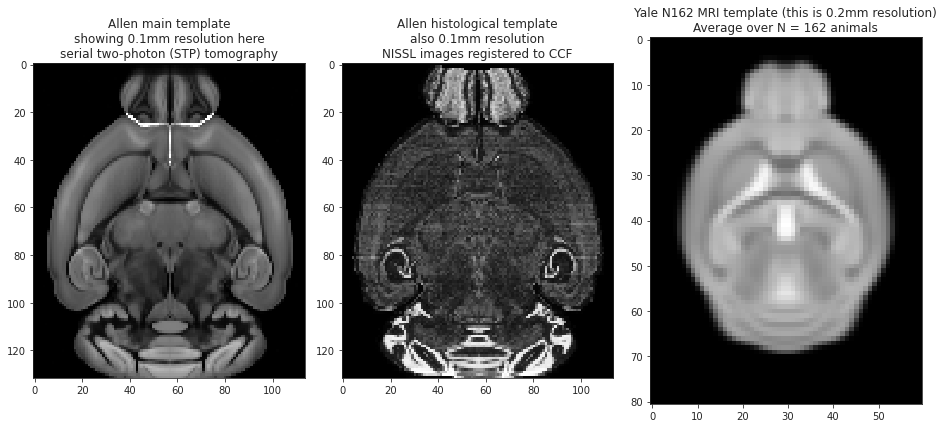

In [14]:
mice = Mice(Config(32))

from register.register import *
reg = Register(mice)

fig, axes = create_figure(1, 3, (13, 6.5))
axes[0].imshow(reg.template[:, 40, :], cmap='Greys_r')
axes[1].imshow(reg.nissl[:, 40, :], cmap='Greys_r')
axes[2].imshow(reg.in_house[:, 13, :], cmap='Greys_r')

axes[0].set_title('Allen main template\nshowing 0.1mm resolution here\nserial two-photon (STP) tomography')
axes[1].set_title('Allen histological template\nalso 0.1mm resolution\nNISSL images registered to CCF')
axes[2].set_title('Yale N162 MRI template (this is 0.2mm resolution)\nAverage over N = 162 animals')

plt.show()

- Left: Allen main template:
    - Serial two-photon (STP) tomography.
    - I used this to register fMRI data but Xilin told me NISSL is more suitable, has better contrast
- Middle: Allen histological template:
    - NISSL images in the same common coordinates.
    - Now I'm redoing the registration using this.
    - Already seeing some improvements.
- Right: Yale MRI template:
    - Average over N = 162 animals.
    - This is before registration that's why it looks so different.

## Latest results (with subcortical)

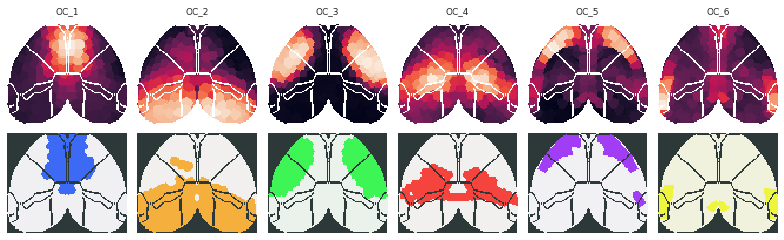

In [15]:
svinet = SVINET(mice, k, p, 'sub-SLC', verbose=False)
svinet.show(group['pi_avg'], figsize=(11, 3.5))

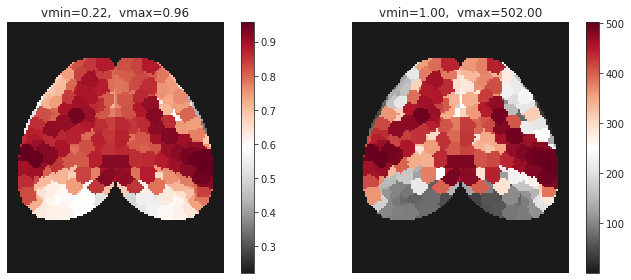

In [16]:
eh = entropy_expect_beta(gam_avg)
ehr = sp_stats.rankdata(eh)

fig, axes = create_figure(1, 2, (10, 4))

for i, ax in enumerate(axes.ravel()):
    data2plt = eh if i == 0 else ehr
    mask = svinet.pi2arr(data2plt.reshape(1, -1), cortex_only=True)[1]
    im = ax.imshow(mask, vmin=min(data2plt), vmax=max(data2plt), cmap='RdGy_r')
    plt.colorbar(im, ax=ax)
    ax.set_title(f"vmin={min(data2plt):0.2f},  vmax={max(data2plt):0.2f}")
remove_ticks(axes)

## Compute $Y_{ij}$

In [24]:
y, y_avg = node_sim_matrix(group)
y.shape, y_avg.shape

((10, 502, 502), (502, 502))

In [25]:
np.isnan(y).sum(), np.isnan(y_avg).sum()

(0, 0)

### Brief t-SNE before moving on

In [26]:
from sklearn.manifold import TSNE
y_emb = TSNE(
    n_components=2,
    perplexity=30,
    random_state=mice.cfg.random_state,
).fit_transform(y_avg)
y_emb.shape

(502, 2)

In [27]:
hemis = np.array(['R'] * len(svinet.n2l))
hemis[svinet.l_ids] = 'L'

cortex_subcortex = np.array(['Subcortex'] * len(svinet.n2l))
cortex_subcortex[[str(315) in e for e in svinet.l2n]] = 'Cortex'

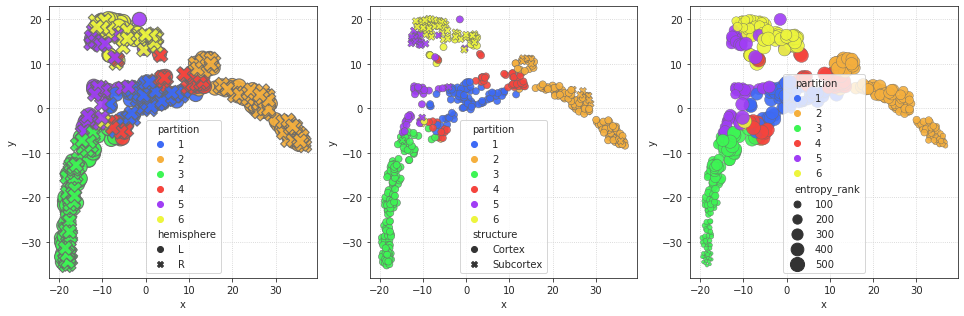

In [28]:
fig, axes = create_figure(1, 3, (13.5, 4.5), 'ticks')

_df = pd.DataFrame({
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(pi_avg, axis=0),
    'structure': cortex_subcortex,
    'hemisphere': hemis,
    'entropy': eh,
    'entropy_rank': ehr,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    style='hemisphere',
    markers={'L': 'o', 'R': 'X'},
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    style='structure',
    markers={'Cortex': 'o', 'Subcortex': 'X'},
    palette=svinet.colors,
    s=50,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    size='entropy_rank',
    sizes=(10, 200),
    palette=svinet.colors,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[2],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

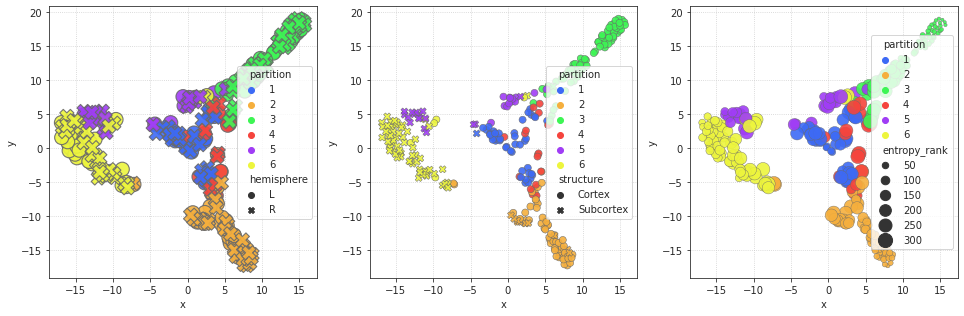

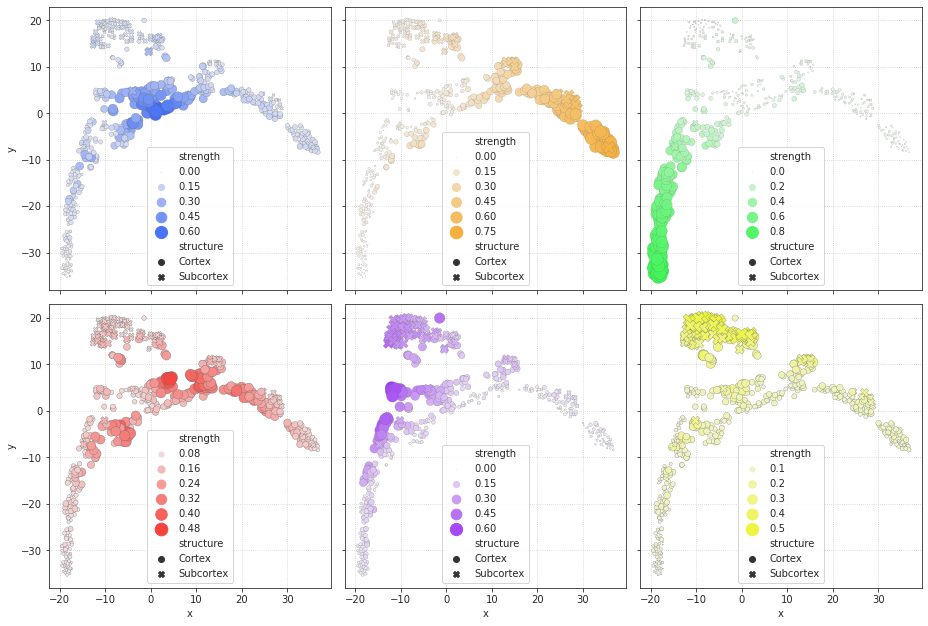

In [38]:
nrows = 2
ncols = int(np.ceil(k / nrows))
fig, axes = create_figure(nrows, ncols, (13, 4.4 * nrows), 'ticks', 'all', 'all')

for i, ax in enumerate(axes.ravel()):
    if i == k:
        break

    _df = pd.DataFrame({
        'x': y_emb[:, 0],
        'y': y_emb[:, 1],
        'hemisphere': hemis,
        'structure': cortex_subcortex,
        'strength': np.round(pi_avg[i, :], 2),
    })
    sns.scatterplot(
        data=_df,
        x='x',
        y='y',
        hue='strength',
        size='strength',
        style='structure',
        sizes=(1, 160),
        palette=svinet.cmaps[i+1],
        s=120,
        edgecolor='dimgrey',
        ax=ax,
    )
    # ax.set_xlim((ax.get_xlim()[0], 44))
    ax.legend(loc="lower center")
    ax.grid()
trim_axs(axes, k)
plt.show()

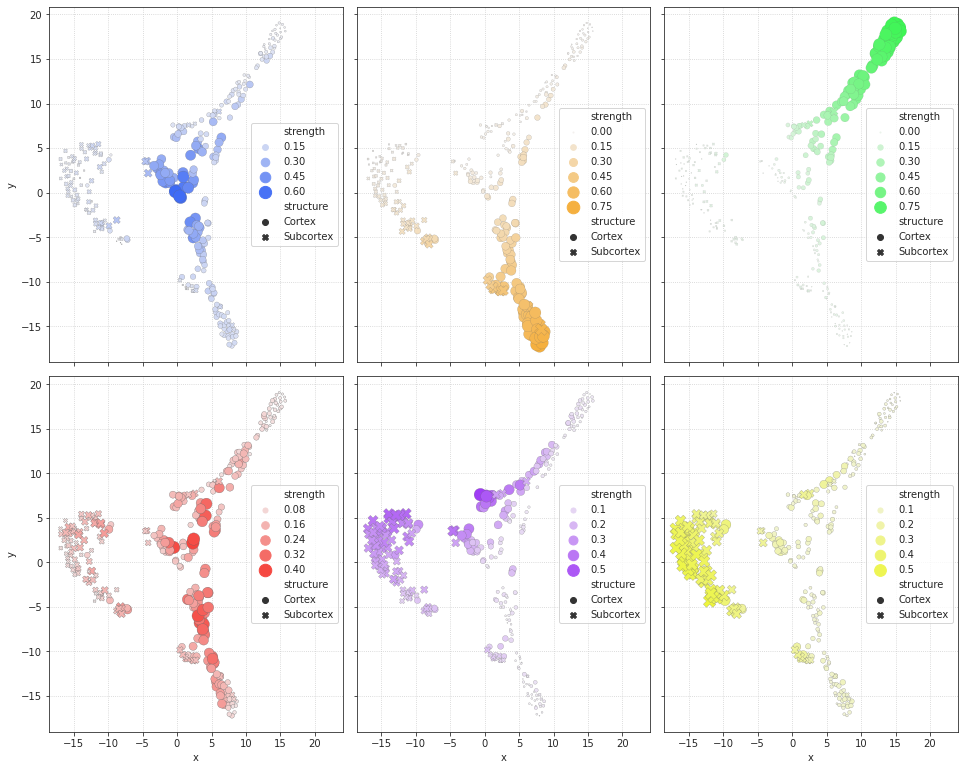